<a href="https://colab.research.google.com/github/RuiaRui/project_CSM/blob/main/CSM_ML_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline

In [ ]:
! pip install bertopic
! pip install pynndescent==0.5
# need restart run this first

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 5.8 MB/s 
     |████████████████████████████████| 5.2 MB 31.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 88 kB 8.5 MB/s 
     |████████████████████████████████| 79 kB 6.7 MB/s 
     |████████████████████████████████| 4.2 MB 50.3 MB/s 
     |████████████████████████████████| 1.2 MB 52.5 MB/s 
     |████████████████████████████████| 86 kB 6.9 MB/s 
     |████████████████████████████████| 6.6 MB 57.9 MB/s 
     |████████████████████████████████| 636 kB 63.7 MB/s 
     |████████████████████████████████| 1.1 MB 49.5 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2342165 sha256=b5f0341ec18ecabbba4c9444d482c14e45c9631f6b6ae61237bb8a85edc7a916
  Stored in directory: /root/.cache/p

In [ ]:
import bz2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm.notebook import tqdm
import dill
import csv

### Load Data

In [ ]:
path=f'/content/drive/MyDrive/CSM_Project/full_data.json.bz2'
df_full=pd.read_json(path)
df_full.head(5)

,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,...,original_tweet_id,original_tweet_userid,original_tweet_username,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username
0,111091623,eilymurphy,Business ELT teacher in France - RTs are not e...,None,1335,1612,4781,2010-02-03 19:53:11.000000,1509682278514970628,2022-04-01 00:01:18.000000,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None
1,1411655223752413184,clayella8585,None,None,52,663,32045,2021-07-04 11:58:41.000000,1509682320630026241,2022-04-01 00:01:28.000000,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None
2,1147634388064186369,FrankPentangel1,Alive and kicking,None,132,98,9779,2019-07-06 22:32:14.000000,1509682449042878464,2022-04-01 00:01:59.000000,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None
3,24756899,Faith4Mishel,"💎 CLASSY, Sassy AND a little 💎 SMART assy! In...","Floriduh, USA",4678,6402,58179,2009-03-16 19:57:53.000000,1509682747018817538,2022-04-01 00:03:10.000000,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None
4,1377044106141171713,chaplainoftruth,Evangelist and a Chaplain for Go Ministry\nLas...,None,229,49,2240,2021-03-30 23:45:04.000000,1509682961377120257,2022-04-01 00:04:01.000000,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None


In [ ]:
df_full['tweetcreatedts']=df_full.tweetcreatedts.apply(pd.to_datetime)
df_full

,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,...,original_tweet_id,original_tweet_userid,original_tweet_username,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username
0,111091623,eilymurphy,Business ELT teacher in France - RTs are not e...,None,1335,1612,4781,2010-02-03 19:53:11.000000,1509682278514970628,2022-04-01 00:01:18,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None
1,1411655223752413184,clayella8585,None,None,52,663,32045,2021-07-04 11:58:41.000000,1509682320630026241,2022-04-01 00:01:28,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None
2,1147634388064186369,FrankPentangel1,Alive and kicking,None,132,98,9779,2019-07-06 22:32:14.000000,1509682449042878464,2022-04-01 00:01:59,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None
3,24756899,Faith4Mishel,"💎 CLASSY, Sassy AND a little 💎 SMART assy! In...","Floriduh, USA",4678,6402,58179,2009-03-16 19:57:53.000000,1509682747018817538,2022-04-01 00:03:10,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None
4,1377044106141171713,chaplainoftruth,Evangelist and a Chaplain for Go Ministry\nLas...,None,229,49,2240,2021-03-30 23:45:04.000000,1509682961377120257,2022-04-01 00:04:01,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64584,1151684730,RachelMorganPhD,Impact Project Officer @swanseauni | Latin Ame...,"Rhondda, Cymru",8729,7938,2627,2013-02-05 18:50:17.000000,1509676297617920002,2022-03-31 23:37:32,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None
64585,2307337790,coenfrancine,Vice presidente B'nai B'rith France@ B'nai B'r...,marseille,211,52,1559,2014-01-23 22:34:49.000000,1509676341012094986,2022-03-31 23:37:42,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None
64586,404397059,TGEUorg,TGEU is a membership-based organisation workin...,Europe & Central Asia,489,12086,4297,2011-11-03 21:31:37.000000,1509676585141551105,2022-03-31 23:38:40,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None
64587,1228193467,JakubHlavka,Assistant Research Professor @USCPrice @Schaef...,Stand with Ukraine,4996,995,1273,2013-02-28 19:05:52.000000,1509676861785214979,2022-03-31 23:39:46,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None


In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64589 entries, 0 to 64588
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   userid                   64589 non-null  int64         
 1   username                 64589 non-null  object        
 2   acctdesc                 58907 non-null  object        
 3   location                 47178 non-null  object        
 4   following                64589 non-null  int64         
 5   followers                64589 non-null  int64         
 6   totaltweets              64589 non-null  int64         
 7   usercreatedts            64589 non-null  object        
 8   tweetid                  64589 non-null  int64         
 9   tweetcreatedts           64589 non-null  datetime64[ns]
 10  retweetcount             64589 non-null  int64         
 11  text                     64589 non-null  object        
 12  hashtags                 64589 n

In [ ]:
df_full.text.head(5).apply(print)

Here s the link to our therapeutic tale for #refugee children from #Ukraine. In two language versions  UKR and RUS . PL and ENG translations available. #HelpUkraine  URL  Pleast, please RT
Russian Nobel peace prize winner sells medal to fund for Ukrainian refugees #StopPutin #StandWithUkraine URL
I see #ColmOGorman hasn t volunteered to look after, say, two disabled refugees from #Ukraine. Why not? Surly Colm knows how important it is for Secular Saints to lead from the front. He hasn t refused, has he? URL
#IMMIGRATION #Biden Admin lifts #Trump era #Title42 which W.H. admits will create  influx  of #migrants  URL
A refugee from #Mariupol tells how the AFU #Azov fired at their car with children while they were trying to leave the city. #Ukraine URL


0    None
1    None
2    None
3    None
4    None
Name: text, dtype: object

## Sentimental Analysis - ROBERTa-twitter

In [ ]:
! pip install transformers
! pip install sentencepiece

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import urllib.request
from scipy.special import softmax

In [ ]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)


Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [ ]:
model = model.to(device)

In [ ]:
tensors = []
for tweet in tqdm(df_full.text):
    encoded_input = tokenizer(tweet, return_tensors='pt').to("cuda:0")
    output = model(**encoded_input)
    tensors.append(output[0][0].detach())

  0%|          | 0/64589 [00:00<?, ?it/s]

In [ ]:
tweets_scores = []
for t in tensors:
    scores = t.cpu().numpy()
    scores = softmax(scores)
    tweets_scores.append(scores)

In [ ]:
df_full['score']=tweets_scores

In [ ]:
df_full['negative_sentiment'] = [x[0] for x in df_full['score']]
df_full['neutral_sentiment'] = [x[1] for x in df_full['score']]
df_full['positive_sentiment'] = [x[2] for x in df_full['score']]
df_full['max_sentiment'] = [labels[np.argmax(x)] for x in df_full['score']]


In [ ]:
df_sentiment = df_full[['tweetid','text','tweetcreatedts','location','hashtags','coordinates','score','max_sentiment','negative_sentiment','neutral_sentiment','positive_sentiment']]
df_sentiment.head(10)

,tweetid,text,tweetcreatedts,location,hashtags,coordinates,score,max_sentiment,negative_sentiment,neutral_sentiment,positive_sentiment
0,1509682278514970628,Here s the link to our therapeutic tale for #r...,2022-04-01 00:01:18,None,"[{'text': 'refugee', 'indices': [62, 70]}, {'t...",None,"[0.03245182, 0.7045272, 0.263021]",neutral,0.032452,0.704527,0.263021
1,1509682320630026241,Russian Nobel peace prize winner sells medal t...,2022-04-01 00:01:28,None,"[{'text': 'StopPutin', 'indices': [90, 100]}, ...",None,"[0.32782963, 0.6390246, 0.033145748]",neutral,0.327830,0.639025,0.033146
2,1509682449042878464,I see #ColmOGorman hasn t volunteered to look ...,2022-04-01 00:01:59,None,"[{'text': 'ColmOGorman', 'indices': [6, 18]}, ...",None,"[0.5628299, 0.40572208, 0.03144796]",negative,0.562830,0.405722,0.031448
3,1509682747018817538,#IMMIGRATION #Biden Admin lifts #Trump era #Ti...,2022-04-01 00:03:10,"Floriduh, USA","[{'text': 'IMMIGRATION', 'indices': [0, 12]}, ...",None,"[0.14866996, 0.7311173, 0.12021264]",neutral,0.148670,0.731117,0.120213
4,1509682961377120257,A refugee from #Mariupol tells how the AFU #Az...,2022-04-01 00:04:01,None,"[{'text': 'Mariupol', 'indices': [33, 42]}, {'...",None,"[0.785562, 0.20906815, 0.0053699417]",negative,0.785562,0.209068,0.005370
5,1509683141841096718,I m on a longer assignment in #Warsaw #Poland ...,2022-04-01 00:04:44,None,"[{'text': 'Warsaw', 'indices': [47, 54]}, {'te...",None,"[0.46412823, 0.45448253, 0.08138933]",negative,0.464128,0.454483,0.081389
6,1509684253939970051,Here is a very emotional thank you video fro...,2022-04-01 00:09:09,Комната,"[{'text': 'Ukrainian', 'indices': [67, 77]}, {...",None,"[0.01120699, 0.16306007, 0.825733]",positive,0.011207,0.163060,0.825733
7,1509684283237089282,THE HUMAN COST OF WAR As conflict escalates i...,2022-04-01 00:09:16,"New York, Los Angeles","[{'text': 'Ukraine', 'indices': [52, 60]}]",None,"[0.31164145, 0.5444201, 0.14393847]",neutral,0.311641,0.544420,0.143938
8,1509685234131898377,VerstyukIvan .. Great News from the Taprooms ...,2022-04-01 00:13:03,None,"[{'text': 'Ukraine', 'indices': [151, 159]}]",None,"[0.005130474, 0.0907974, 0.9040722]",positive,0.005130,0.090797,0.904072
9,1509685341120311300,Next 9 April the EU will become one with #Ukr...,2022-04-01 00:13:28,"Canberra, Australia","[{'text': 'Ukraine', 'indices': [44, 52]}, {'t...",None,"[0.004674135, 0.55220413, 0.44312188]",neutral,0.004674,0.552204,0.443122


In [ ]:
df_sentiment.to_json('/content/drive/MyDrive/CSM_Project/full_data_sentiment.json.bz2')

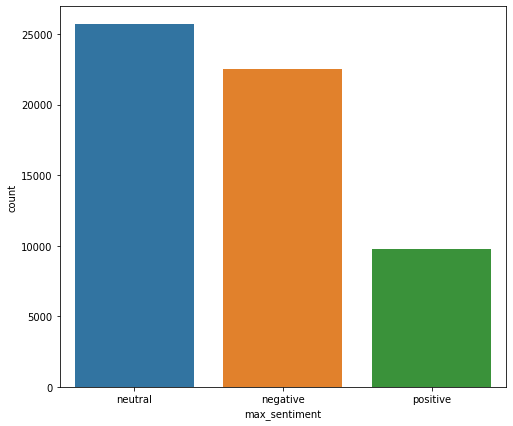

In [ ]:
plt.figure(figsize = (8,7))
sns.countplot(x="max_sentiment", data=df_sentiment.drop_duplicates(subset=['text']))

In [ ]:
df_full.text.loc[328]

'This morning, I thanked President  sandumaiamd for the way the Republic of Moldova handles the refugee crisis, for the benefit of the entire continent.  Our thanks, of the  Europarl EN, also go to the citizens of Moldova, who have warmly helped the refugees from #Ukraine. 1 2 URL'

In [ ]:
df_full.max_sentiment.loc[328]

'positive'

In [ ]:
for t in df_full[df_full['max_sentiment']=='negative'].text.head(10):
  print(t)
  print('\n')

I see #ColmOGorman hasn t volunteered to look after, say, two disabled refugees from #Ukraine. Why not? Surly Colm knows how important it is for Secular Saints to lead from the front. He hasn t refused, has he? URL


A refugee from #Mariupol tells how the AFU #Azov fired at their car with children while they were trying to leave the city. #Ukraine URL


I m on a longer assignment in #Warsaw #Poland covering refugees from #ukraine. Opened my suitcase to letters from my kids  to be opened through my stay here. A reminder of the importance of home to carry me on this heartbreaking story of millions losing their homes in this war URL


  Because is a landlocked country WITHOUT a navy, nuclear bombs, etc. Because is neutral Because accepts Ukrainian refugees Because Armenians help Ukrainians Because Artsakh send 140 tons of humanitarian aid Because this is FAKE NEWS  #Ukraine #Armenia URL


Anyone saying that the #Ukraine conflict started in Feb is either lying or is clueless. The world has

## BERTopic

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=200, 
                        metric='euclidean', 
                        cluster_selection_method='eom', 
                        prediction_data=True, 
                        min_samples=5)

vectorizer_model = CountVectorizer(ngram_range=(1, 2), 
                                   stop_words="english", 
                                   min_df=10, 
                                   max_df=0.95)

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(verbose=True,
                 embedding_model='all-mpnet-base-v2', 
                 vectorizer_model=vectorizer_model,
                 hdbscan_model=hdbscan_model,
                 calculate_probabilities=False,
                 min_topic_size=100,
                 nr_topics="auto")

In [ ]:
topics, probs = topic_model.fit_transform(df_full.text)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Batches:   0%|          | 0/2019 [00:00<?, ?it/s]

2022-06-08 21:18:36,704 - BERTopic - Transformed documents to Embeddings
2022-06-08 21:20:27,685 - BERTopic - Reduced dimensionality
2022-06-08 21:20:34,294 - BERTopic - Clustered reduced embeddings
2022-06-08 21:20:47,440 - BERTopic - Reduced number of topics from 50 to 27


In [ ]:
topics_df=topic_model.get_topic_info()
topics_df.to_json('/content/drive/MyDrive/CSM_Project/topics.json')
topics_df

,Topic,Count,Name
0,0,24052,0_uk_eu_borders_government
1,-1,20924,-1_eu_nato_food_civilians
2,1,2536,1_racism_white_black_african
3,2,2495,2_fled ukraine_million people_million refugees...
4,3,1602,3_donation_supplies_donated_donating
5,4,1450,4_child_unicef_women children_men
6,5,1366,5_biden_potus_100 00_president
7,6,835,6_music_song_raise_raised
8,7,824,7_israel_jewish_israeli_jews
9,8,813,8_animals_cat_pet_dog


In [ ]:
topic_model.visualize_topics()

In [ ]:
fig = topic_model.visualize_barchart(top_n_topics=20)
fig.write_html("/content/drive/MyDrive/CSM_Project/topic_word_score.html")
fig

In [ ]:
topic_model.save('/content/drive/MyDrive/CSM_Project/bert_topic_model')

In [ ]:
model_load = BERTopic.load('/content/drive/MyDrive/CSM_Project/bert_topic_model')

In [ ]:
model_load.get_topic_info()

,Topic,Count,Name
0,0,24052,0_uk_eu_borders_government
1,-1,20924,-1_eu_nato_food_civilians
2,1,2536,1_racism_white_black_african
3,2,2495,2_fled ukraine_million people_million refugees...
4,3,1602,3_donation_supplies_donated_donating
5,4,1450,4_child_unicef_women children_men
6,5,1366,5_biden_potus_100 00_president
7,6,835,6_music_song_raise_raised
8,7,824,7_israel_jewish_israeli_jews
9,8,813,8_animals_cat_pet_dog


In [ ]:
timestamps=df_full.tweetcreatedts.apply(pd.to_datetime).dt.date
timestamps

0        2022-04-01
1        2022-04-01
2        2022-04-01
3        2022-04-01
4        2022-04-01
            ...    
64584    2022-03-31
64585    2022-03-31
64586    2022-03-31
64587    2022-03-31
64588    2022-03-31
Name: tweetcreatedts, Length: 64589, dtype: object

In [ ]:
topics_over_time = topic_model.topics_over_time(df_full.text,topics,timestamps)


89it [00:11,  8.01it/s]


In [ ]:
topics_over_time

,Topic,Words,Frequency,Timestamp,Name
0,-1,"prepared, welcome, eu, russiaukraineconflict, ...",78,2022-02-24,-1_eu_nato_food_civilians
1,0,"hungary, preparing, government, eu, uk",96,2022-02-24,0_uk_eu_borders_government
2,1,"creates, comments, racism, asylum, white",7,2022-02-24,1_racism_white_black_african
3,2,"russia invasion, prepare, receive, refugee age...",14,2022-02-24,2_fled ukraine_million people_million re...
4,3,"base, partnership, ukraine donate, sell, aid u...",2,2022-02-24,3_donation_supplies_donated_donating
...,...,...,...,...,...
2258,16,"project, ukraine looking, artists, rescueorg, ...",3,2022-05-23,16_art_proceeds_artist_artists
2259,17,"missed, identify, unhcr url, amnesty, strategy",2,2022-05-23,17_podcast_listen_episode_latest
2260,18,"planning, men, care, url really, representatives",5,2022-05-23,18_standupforukraine_stand_glblctzn_supp...
2261,20,"leave homes, care ukrainian, forced leave, ref...",1,2022-05-23,20_medical_health_hospital_field


In [ ]:

fig = topic_model.visualize_topics_over_time(topics_over_time)
fig.write_html("/content/drive/MyDrive/CSM_Project/topic_over_time.html")
fig

In [ ]:
df_full['topics']=topics
df_full.head(5)

,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,...,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username,score,negative_sentiment,neutral_sentiment,positive_sentiment,max_sentiment,topics
0,111091623,eilymurphy,Business ELT teacher in France - RTs are not e...,None,1335,1612,4781,2010-02-03 19:53:11.000000,1509682278514970628,2022-04-01 00:01:18,...,NaN,NaN,NaN,None,"[0.03245182, 0.7045272, 0.263021]",0.032452,0.704527,0.263021,neutral,24
1,1411655223752413184,clayella8585,None,None,52,663,32045,2021-07-04 11:58:41.000000,1509682320630026241,2022-04-01 00:01:28,...,NaN,NaN,NaN,None,"[0.32782963, 0.6390246, 0.033145748]",0.327830,0.639025,0.033146,neutral,-1
2,1147634388064186369,FrankPentangel1,Alive and kicking,None,132,98,9779,2019-07-06 22:32:14.000000,1509682449042878464,2022-04-01 00:01:59,...,NaN,NaN,NaN,None,"[0.5628299, 0.40572208, 0.03144796]",0.562830,0.405722,0.031448,negative,0
3,24756899,Faith4Mishel,"💎 CLASSY, Sassy AND a little 💎 SMART assy! In...","Floriduh, USA",4678,6402,58179,2009-03-16 19:57:53.000000,1509682747018817538,2022-04-01 00:03:10,...,NaN,NaN,NaN,None,"[0.14866996, 0.7311173, 0.12021264]",0.148670,0.731117,0.120213,neutral,0
4,1377044106141171713,chaplainoftruth,Evangelist and a Chaplain for Go Ministry\nLas...,None,229,49,2240,2021-03-30 23:45:04.000000,1509682961377120257,2022-04-01 00:04:01,...,NaN,NaN,NaN,None,"[0.785562, 0.20906815, 0.0053699417]",0.785562,0.209068,0.005370,negative,10


In [ ]:
df_sentiment['topic'] = topics
df_sentiment.head()


,tweetid,text,tweetcreatedts,location,hashtags,coordinates,score,max_sentiment,negative_sentiment,neutral_sentiment,positive_sentiment,topic
0,1509682278514970628,Here s the link to our therapeutic tale for #r...,2022-04-01 00:01:18,None,"[{'text': 'refugee', 'indices': [62, 70]}, {'t...",None,"[0.03245182, 0.7045272, 0.263021]",neutral,0.032452,0.704527,0.263021,24
1,1509682320630026241,Russian Nobel peace prize winner sells medal t...,2022-04-01 00:01:28,None,"[{'text': 'StopPutin', 'indices': [90, 100]}, ...",None,"[0.32782963, 0.6390246, 0.033145748]",neutral,0.327830,0.639025,0.033146,-1
2,1509682449042878464,I see #ColmOGorman hasn t volunteered to look ...,2022-04-01 00:01:59,None,"[{'text': 'ColmOGorman', 'indices': [6, 18]}, ...",None,"[0.5628299, 0.40572208, 0.03144796]",negative,0.562830,0.405722,0.031448,0
3,1509682747018817538,#IMMIGRATION #Biden Admin lifts #Trump era #Ti...,2022-04-01 00:03:10,"Floriduh, USA","[{'text': 'IMMIGRATION', 'indices': [0, 12]}, ...",None,"[0.14866996, 0.7311173, 0.12021264]",neutral,0.148670,0.731117,0.120213,0
4,1509682961377120257,A refugee from #Mariupol tells how the AFU #Az...,2022-04-01 00:04:01,None,"[{'text': 'Mariupol', 'indices': [33, 42]}, {'...",None,"[0.785562, 0.20906815, 0.0053699417]",negative,0.785562,0.209068,0.005370,10


In [ ]:
df_full['tweetcreatedts'] = df_full['tweetcreatedts'].astype(str)
df_full.to_json("/content/drive/MyDrive/CSM_Project/tweet_full_done.json.bz2")
df_sentiment['tweetcreatedts'] = df_sentiment['tweetcreatedts'].astype(str)
df_sentiment.to_json('/content/drive/MyDrive/CSM_Project/tweet_full_done_filter.json.bz2')

# Analysis

In [ ]:
topics_df = pd.read_json('/content/drive/MyDrive/CSM_Project/topics.json')

In [ ]:
df_result = pd.read_json('/content/drive/MyDrive/CSM_Project/tweet_full_done_filter.json.bz2')

df_result.head()

,tweetid,text,tweetcreatedts,location,hashtags,coordinates,score,max_sentiment,negative_sentiment,neutral_sentiment,positive_sentiment,topic
0,1509682278514970628,Here s the link to our therapeutic tale for #r...,2022-04-01 00:01:18,None,"[{'text': 'refugee', 'indices': [62, 70]}, {'t...",None,"[0.0324518196, 0.7045271993000001, 0.263020992...",neutral,0.032452,0.704527,0.263021,24
1,1509682320630026241,Russian Nobel peace prize winner sells medal t...,2022-04-01 00:01:28,None,"[{'text': 'StopPutin', 'indices': [90, 100]}, ...",None,"[0.32782962920000003, 0.6390246153, 0.03314574...",neutral,0.327830,0.639025,0.033146,-1
2,1509682449042878464,I see #ColmOGorman hasn t volunteered to look ...,2022-04-01 00:01:59,None,"[{'text': 'ColmOGorman', 'indices': [6, 18]}, ...",None,"[0.5628299117000001, 0.4057220817, 0.0314479582]",negative,0.562830,0.405722,0.031448,0
3,1509682747018817538,#IMMIGRATION #Biden Admin lifts #Trump era #Ti...,2022-04-01 00:03:10,"Floriduh, USA","[{'text': 'IMMIGRATION', 'indices': [0, 12]}, ...",None,"[0.1486699581, 0.7311173081, 0.1202126369]",neutral,0.148670,0.731117,0.120213,0
4,1509682961377120257,A refugee from #Mariupol tells how the AFU #Az...,2022-04-01 00:04:01,None,"[{'text': 'Mariupol', 'indices': [33, 42]}, {'...",None,"[0.7855619788, 0.2090681493, 0.0053699417]",negative,0.785562,0.209068,0.005370,10


In [ ]:
df_result['date']=df_result.tweetcreatedts.apply(pd.to_datetime).dt.date

In [ ]:
for t in df_result[df_result['max_sentiment']=='negative'].sort_values(by='negative_sentiment',ascending=False).text.head():
  print(t)
  print('\n')
#df_result[df_result['max_sentiment']=='negative'].sort_values(by='negative_sentiment',ascending=False).text.head(10)

Unfortunately I can t call the UK government racist anymore they seem to show the same contempt and inhumanity to white refugees too! I hate this tory government with a burning passion! #UkraineRussianWar URL


I think today I reached my breaking point, after so much of emotional roller coaster, so much hate towards Ukraine by the agressors, so many lives lost, homes destroyed, refugees in despair, broken families and for what?  This war is an absolute insanity. #RussianUkrainianWar


  crying. Why do children have to go through this? Damn you, all disgusting warmongers. URL #Ukraine #refugees URL




In [ ]:
for t in df_result[df_result['max_sentiment']=='neutral'].sort_values(by='neutral_sentiment',ascending=False).text.head():
  print(t)
  print('\n')


U.S. Vice President Kamala Harris is due to meet later today with Romania s President to discuss a response to the influx of refugees from #Ukraine.


The #Canadian authorities will organize three flights from #Poland for #Ukrainian refugees in late May early June, media reported. URL


Ottawa chartering 3 flights for Ukrainian refugees over next month #Ukraine URL


#Japan plans to send SDF aircraft for #Ukraine refugee aid this month  URL


#Japan plans to send SDF aircraft for #Ukraine refugee aid this month  URL




In [ ]:
for t in df_result[df_result['max_sentiment']=='positive'].sort_values(by='positive_sentiment',ascending=False).text.head(10):
  print(t)
  print('\n')


Wow. I just discovered #LittleAmerica on #AppleTV. What heartwarming and motivational stories. I love it! I highly recommend it. #immigrants #USA  AppleTV


I am SO excited for this great tool!! It s such a great way to find family members across censuses and will be a great help for the #1950Census as well! Love it!! Well done  MyHeritage !! #Census #RecensementUS #USA #USImmigrants #genealogy #familyhistory URL


On Tuesday this week my partner and I welcomed a Ukrainian refugee couple into our home. They have settled in really well. They are a wonderful couple and we are really enjoying getting to know them. #SlavaUkraini URL


So good news  The Ukrainian refugees from Kharkiv my family is sponsoring are going to be in the air tomorrow! My family is so excited . #toronto #canada #ukraine  peggy blair  RosemarieDAmico URL


1,205 followers! Thank you! I really appreciate all of you, and so here s a shoutout  please check out this really cool fundraiser for #Ukraine and #Ukrainian ref

In [ ]:
df_senti_date=df_result.groupby(['date'])['negative_sentiment','neutral_sentiment','positive_sentiment'].mean()
df_senti_date['sentiment'] = df_senti_date.positive_sentiment - df_senti_date.negative_sentiment
df_senti_date.reset_index(inplace=True)
df_senti_date

,date,negative_sentiment,neutral_sentiment,positive_sentiment,sentiment
0,2022-02-24,0.363341,0.495333,0.141326,-0.222014
1,2022-02-25,0.351730,0.452206,0.196063,-0.155667
2,2022-02-26,0.405588,0.409153,0.185260,-0.220328
3,2022-02-27,0.386679,0.434697,0.178624,-0.208055
4,2022-02-28,0.386340,0.429414,0.184246,-0.202095
...,...,...,...,...,...
84,2022-05-19,0.321757,0.445823,0.232420,-0.089338
85,2022-05-20,0.328604,0.451285,0.220110,-0.108494
86,2022-05-21,0.384112,0.399910,0.215979,-0.168133
87,2022-05-22,0.364583,0.461873,0.173544,-0.191039


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.line(df_senti_date, x='date', y="sentiment")
fig.update_layout(title='Average Sentiments over time',
                    xaxis_title="Date",
                    yaxis_title="Sentiment index",)
fig.update_yaxes(range=[-0.5, 0.2])
fig.show()


In [ ]:
fig.write_html("/content/drive/MyDrive/CSM_Project/result/sentiment_over_time.html")

In [ ]:
# fig = go.Figure(layout_xaxis_range=[2007,2021])
fig = go.Figure(layout_yaxis_range=[-1,1])
colors = px.colors.qualitative.G10 + px.colors.qualitative.Antique + px.colors.qualitative.Vivid
fig.add_traces(go.Scatter(x=df_senti_date['date'], y = df_senti_date['sentiment'], name='all_topic_average', marker=dict(
        color=colors[0])))


for index, row in topics_df[['Topic','Name']].iterrows():
    df_temp = df_result[df_result['topic']==row['Topic']]

    df_temp=df_temp.groupby(['date'])['negative_sentiment','neutral_sentiment','positive_sentiment'].mean()
    df_temp['senti'] = df_temp.positive_sentiment - df_temp.negative_sentiment
    df_temp.reset_index(inplace=True)

    fig.add_traces(go.Scatter(x=df_temp['date'], y = df_temp['senti'], name=row['Name'], marker=dict(
        color=colors[index+1]), visible='legendonly'
        ))
    
fig.update_layout(height=int(600))
fig.update_layout(title='Topic sentiments over time',
                    xaxis_title="Date",
                    yaxis_title="Sentiment index",)
fig.show()

In [ ]:
fig.write_html("/content/drive/MyDrive/CSM_Project/result/topic_sentiment_over_time.html")

In [ ]:
df_senti_topic=df_result.groupby(['topic'])['negative_sentiment','neutral_sentiment','positive_sentiment'].mean()
df_senti_topic['sentiment'] = df_senti_topic.positive_sentiment - df_senti_topic.negative_sentiment
df_senti_topic.reset_index(inplace=True)
df_senti_topic=pd.merge(df_senti_topic,topics_df,left_on='topic',right_on='Topic')


fig = px.bar(df_senti_topic, x='Name', y='sentiment',
             hover_data=['Count', 'Name'], 
             labels={'pop':'sentiment Index'}, height=900)
fig.update_layout(title='Topic Sentiments Overall',
                    xaxis_title="Topic",
                    yaxis_title="Sentiment index",)
fig.show()
fig.write_html("/content/drive/MyDrive/CSM_Project/result/topic_sentiment.html")

## Locations

In [ ]:
ridf_result.location.notna().value_counts()

True     47178
False    17411
Name: location, dtype: int64

In [ ]:
df_result.location.dropna().value_counts()

London                            878
London, England                   777
Ukraine                           629
Washington, DC                    615
United States                     584
                                 ... 
Vienna &at large across the EU      1
UK and International                1
New Milford, NJ                     1
Aus Paderborn ✌🏼🤘🏼                  1
Lake Charles, LA                    1
Name: location, Length: 12517, dtype: int64

## HashTags

In [ ]:
def load_json(str):
    str = str.replace("\'", "\"")
    obj=json.loads(str)
    hashtags=[]
    for i in obj:
        # lower case of all hashtags
        hashtags.append(i['text'].lower())
    return hashtags



df_result['hashtag']=df_result.hashtags.apply(load_json)
df_hashtags=df_result.explode('hashtag')

In [ ]:
df_hashtags['sentiment']=df_hashtags.positive_sentiment - df_hashtags.negative_sentiment
df_senti_hashtags=df_hashtags.groupby(['hashtag'])['sentiment'].agg(['count','mean'])
df_senti_hashtags.reset_index(inplace=True)
df_senti_hashtags.sort_values(by='count',ascending=False,inplace=True)

In [ ]:
fig = px.bar(df_senti_hashtags.head(30), x='hashtag', y='mean',
             hover_data=['count'], 
             labels={'pop':'sentiment Index'}, height=400)
fig.update_layout(title='hashtag Sentiments Overall',
                    xaxis_title="Hashtag",
                    yaxis_title="Sentiment index",)
fig.show()
fig.write_html("/content/drive/MyDrive/CSM_Project/result/hashtag_sentiment.html")

## WordCloud

In [ ]:
import wordcloud
wordcloud.__version__

'1.8.1'

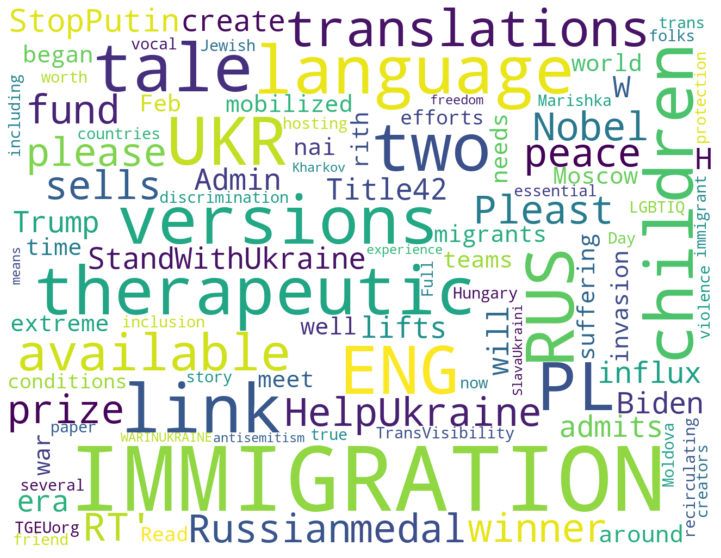

In [ ]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
stopwords.add('Ukraine')
stopwords.add('Ukrainian')
stopwords.add('URL')
stopwords.add("URL'")
stopwords.add('refugee')
stopwords.add('refugees')
stopwords.add('S')
stopwords.add('B')

text = df_result[df_result['max_sentiment'] == 'neutral'].text.values
wordcloud = WordCloud(width=1300, height=1000,background_color="white",stopwords=stopwords).generate(str(text))
fig = plt.figure( figsize=(13,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

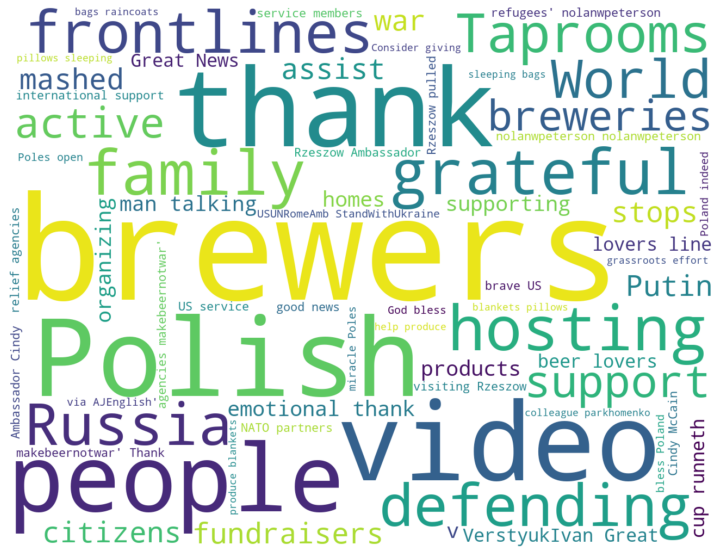

In [ ]:
text = df_result[df_result['max_sentiment'] == 'positive'].text.values
wordcloud = WordCloud(width=1300, height=1000,background_color="white",stopwords=stopwords,collocation_threshold = 2).generate(str(text))
fig = plt.figure( figsize=(13,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

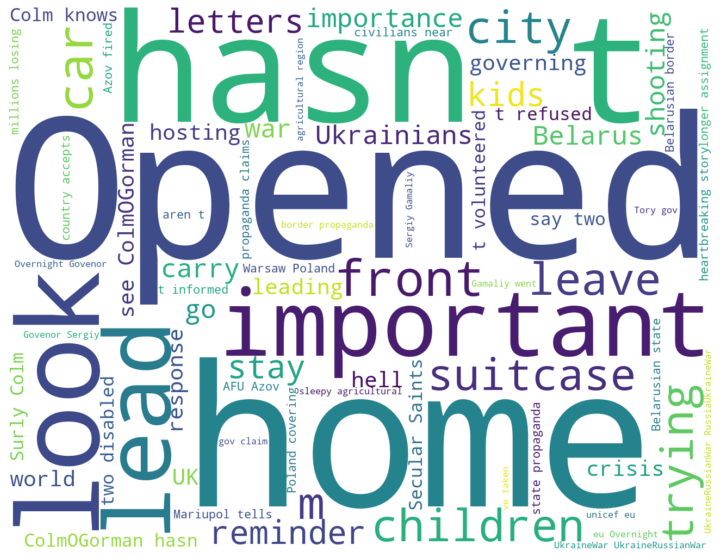

In [ ]:
text = df_result[df_result['max_sentiment'] == 'negative'].text.values
wordcloud = WordCloud(width=1300, height=1000,background_color="white",stopwords=stopwords,collocation_threshold = 2).generate(str(text))
fig = plt.figure( figsize=(13,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

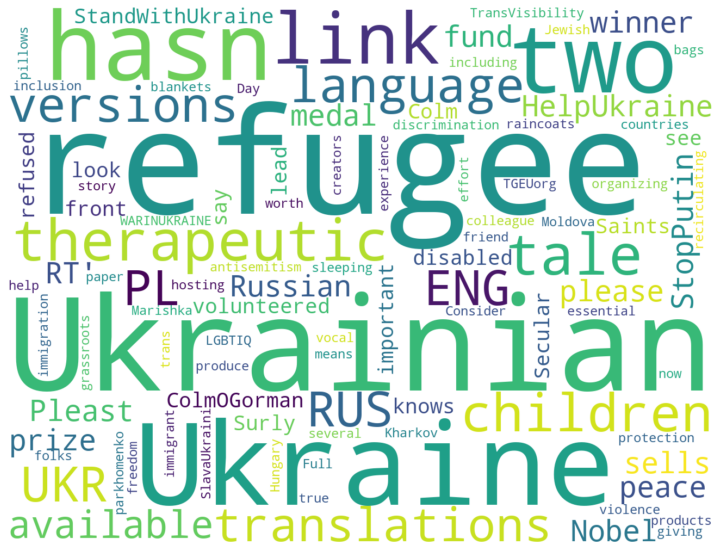

In [ ]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)

stopwords.add('URL')
stopwords.add("URL'")
stopwords.add('S')
stopwords.add('B')

text = df_result.text.values
wordcloud = WordCloud(width=1300, height=1000,background_color="white",stopwords=stopwords).generate(str(text))
fig = plt.figure( figsize=(13,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
df_compare = df_result.groupby(['max_sentiment','date'])['text'].agg(['count'])
df_compare.reset_index(inplace=True)


fig = px.line(df_compare, x='date', y="count",color='max_sentiment')
fig.update_layout(title='English tweets distribution graph by date',
                    xaxis_title="Date",
                    yaxis_title="Sentiment index",)
# fig.update_yaxes(range=[-0.5, 0.2])
fig.show()


In [ ]:
clusters={0: "Politics", 
-1: "None", 
1: "Humanity", 
2: "War", 
3: "Humanity", 
4: "Humanity",
5: "Politics", 
6: "Humanity", 
7: "Politics", 
8: "Humanity", 
9: "Humanity", 
10: "Politics", 
11: "Politics", 
12: "Politics", 
13: "Humanity", 
14: "Humanity", 
15: "Humanity", 
16: "Humanity", 
17: "Humanity", 
18: "Humanity", 
19: "Politics", 
20: "Humanity", 
21: "War", 
22: "Humanity", 
23: "War", 
24: "Humanity", 
25: "Humanity"}



In [ ]:
df_result['cluster']=df_result['topic'].map(clusters)
df_result[df_result['topic']!= -1].cluster.value_counts(normalize=True) 

Politics    0.653590
Humanity    0.274636
War         0.071774
Name: cluster, dtype: float64